# Logistic Regression Model Analysis Walkthrough (Dynamic Rollover)

Logistic regression is a statistical method for predicting binary outcomes from data. It predicts the probability of an instance belonging to the default class, which can be transformed into a binary outcome via a threshold (e.g., if the output probability is > 0.5, classify as class 1, otherwise class 0). The core principle of logistic regression is to establish a relationship between features and the probability of particular outcomes.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import FeatureUnion
from pathlib import Path
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore specific warning categories
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
# this is the path to your pickle file (should be the same location as CSVs)
path = Path('../data')

with open(path / 'dynamic_rollover_pandas_2.0.2.pkl', 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

## Dataset Splitting
We begin by splitting our dataset into a training and testing set. This process ensures that we have a distinct set of data to evaluate the model's performance.

In [3]:
# define independent variables and dependent variable
maneuver = 'Dynamic Rollover'
X = df.drop(maneuver, axis=1)
y = df[maneuver]

In [4]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Build and Fit the Model
We will set up a parameter grid with the best parameters. These parameters were developed in the modeling directory in the decision tree (dynamic rollover) file. For more information on the training and tuning of this model please refer to the modeling file.

In [5]:
# Commented pipelines and parameters represent alternatives that were considered but not chosen for the final model.
# They provide context on what configurations were explored during the model selection process.

# pipe_with_rus = Pipeline([
#     ('scaler', StandardScaler()),
#     ('under', RandomUnderSampler(random_state=42)),
#     ('lr', LogisticRegression())
# ])

# pipe_without_rus = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lr', LogisticRegression())
# ])

# Hyperparameters configurations that were considered:
# params_alternatives = [
#  # params = [
#     {
#         'pipeline': [pipe_with_rus, pipe_without_rus],  # Both pipelines are tested
#         'pipeline__lr__penalty': ['l2', 'none'],
#         'pipeline__lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'pipeline__lr__class_weight': ['balanced'],
#         'pipeline__lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#         'pipeline__lr__fit_intercept': [True, False],
#         'pipeline__lr__random_state': [42],
#         'pipeline__lr__n_jobs': [8],
#         'pipeline__lr__max_iter': [1000]
#     },
#     {
#         'pipeline': [pipe_with_rus, pipe_without_rus],  # Both pipelines are tested
#         'pipeline__lr__penalty': ['l1'],
#         'pipeline__lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'pipeline__lr__class_weight': ['balanced'],
#         'pipeline__lr__solver': ['liblinear', 'saga'],
#         'pipeline__lr__fit_intercept': [True, False],
#         'pipeline__lr__random_state': [42],
#         'pipeline__lr__n_jobs': [8],
#         'pipeline__lr__max_iter': [1000]
#     },
#     {
#         'pipeline': [pipe_with_rus, pipe_without_rus],  # Both pipelines are tested
#         'pipeline__lr__penalty': ['elasticnet'],
#         'pipeline__lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'pipeline__lr__class_weight': ['balanced'],
#         'pipeline__lr__solver': ['saga'],
#         'pipeline__lr__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
#         'pipeline__lr__fit_intercept': [True, False],
#         'pipeline__lr__random_state': [42],
#         'pipeline__lr__n_jobs': [8],
#         'pipeline__lr__max_iter': [1000]
#     }
# ]
# ]

# For this analysis, we've only used the pipeline without RUS.
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])
params = {
    'lr__penalty': ['l2'],
    'lr__C': [1],
    'lr__class_weight': ['balanced'],
    'lr__solver': ['lbfgs'],
    'lr__fit_intercept': [True],
    'lr__random_state': [42],
    'lr__n_jobs': [-1],
    'lr__max_iter': [10000000]
}

## Make Predictions for Model Evaluation

In [6]:
# grid search with cross-validation
f1_scorer = make_scorer(f1_score)
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipe, param_grid=params, cv=strat_k_fold, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1], 'lr__class_weight': ['balanced'],
                         'lr__fit_intercept': [True],
                         'lr__max_iter': [10000000], 'lr__n_jobs': [-1],
                         'lr__penalty': ['l2'], 'lr__random_state': [42],
                         'lr__solver': ['lbfgs']},
             scoring=make_scorer(f1_score))

In [7]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.8105    0.8951     51270
           1     0.0476    0.9511    0.0907       511

    accuracy                         0.8119     51781
   macro avg     0.5235    0.8808    0.4929     51781
weighted avg     0.9900    0.8119    0.8872     51781



In [8]:
print(confusion_matrix(y_test, y_pred))

[[41556  9714]
 [   25   486]]


## Visualizations
These visualizations will provide a comprehensive understanding of the model's performance, the features that drive decisions, and how the model's performance evolves as more data is added.

### Coefficient Analysis
The coefficients of a logistic regression model represent the log-odds of the outcome variable. In simpler terms, a coefficient indicates how the log-odds of the dependent variable change given a one-unit change in the predictor variable, holding all other predictors constant.

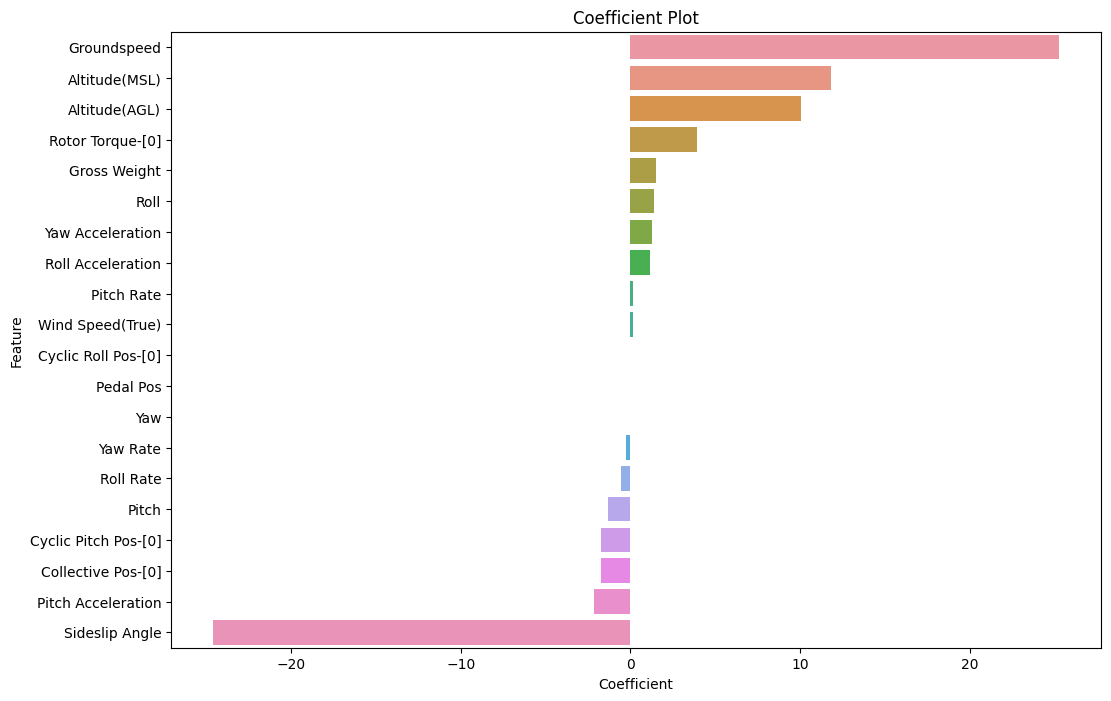

In [9]:
coefficients = grid_search.best_estimator_.named_steps['lr'].coef_[0]
features = X_train.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.title("Coefficient Plot")
plt.show()


- Positive Coefficients: Indicate that as the predictor variable increases, the probability of the outcome occurring also increases.
- Negative Coefficients: Indicate that as the predictor variable increases, the probability of the outcome occurring decreases.

### Probability Distribution

In logistic regression, the outcome is a probability that the given input point belongs to a particular class, which is transformed into a binary outcome via a threshold (e.g., if the output probability is greater than 0.5, classify as class 1, otherwise class 0). The probability distribution plot visualizes the distribution of probabilities predicted by the model for both classes.

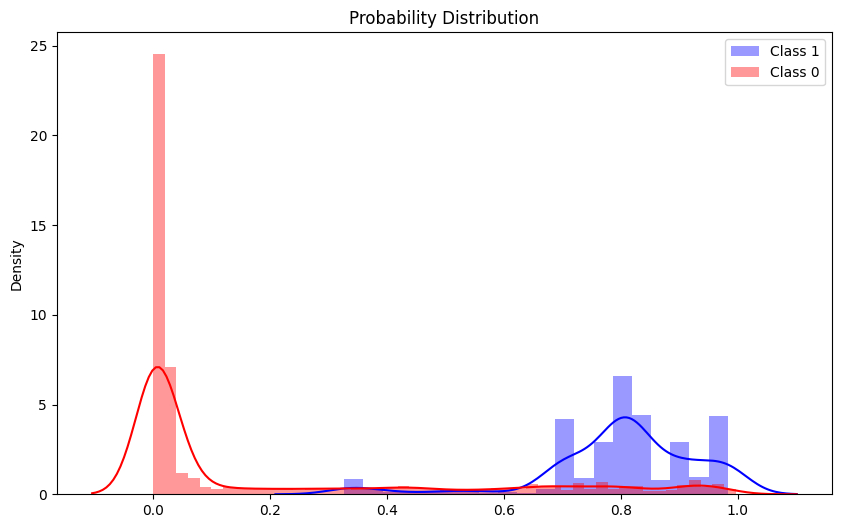

In [10]:
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
sns.distplot(y_pred_prob[y_test == 1], color='b', label='Class 1')
sns.distplot(y_pred_prob[y_test == 0], color='r', label='Class 0')
plt.legend()
plt.title('Probability Distribution')
plt.show()



Overlap between the distributions of the two classes suggests areas where the model might be uncertain.

### Residuals Analysis

Residuals in the context of logistic regression are the differences between the observed binary outcomes and the probabilities predicted by the model. Residual analysis is used to assess the goodness-of-fit of the logistic regression model.

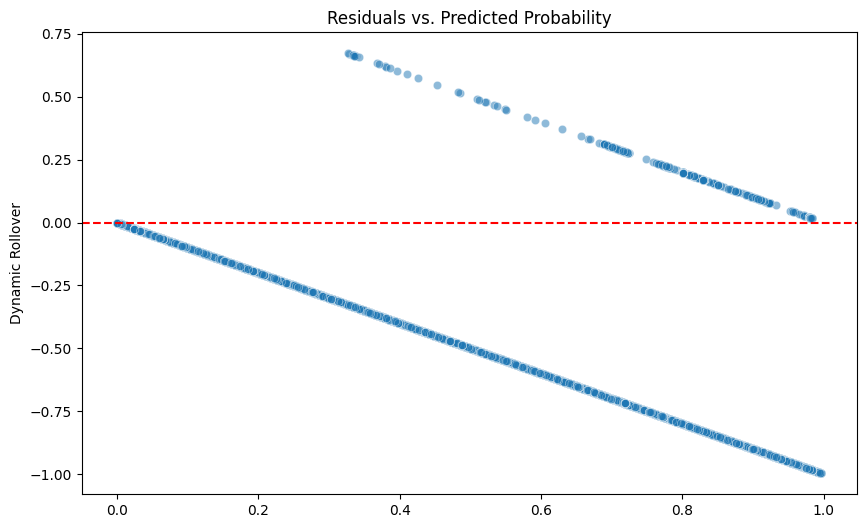

In [11]:
residuals = y_test - y_pred_prob
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_prob, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Probability')
plt.show()

Residuals vs. Predicted Probability Plot: This plot is a scatterplot of residuals on the y-axis and predicted probabilities on the x-axis. The plot can reveal patterns indicating that the model is not fitting certain parts of the data well.